# GPX 3d Viewer App

## Imports

In [1]:
import plotly.express as px
import plotly.graph_objects as go

## GPX to Dataframe

In [2]:
import gpxpy
import pandas as pd

# Load gpx.
gpx_path = 'data/Morvan_day2.gpx'
with open(gpx_path) as f:
    gpx = gpxpy.parse(f)

# Convert to a dataframe one point at a time.
points = []
for segment in gpx.tracks[0].segments:
    for p in segment.points:
        points.append({
            'time': p.time,
            'latitude': p.latitude,
            'longitude': p.longitude,
            'elevation': p.elevation,
        })
df = pd.DataFrame.from_records(points)

## Features Engineering

In [3]:
# Duration
df[['duration']] = df[['time']] - df[['time']].iloc[0]
df['duration'] = df['duration'].apply(str)
df.head()

time   latitude  longitude  elevation         duration
0 2022-11-13 09:06:20+00:00  47.166584   4.110838      627.6  0 days 00:00:00
1 2022-11-13 09:06:21+00:00  47.166606   4.110829      627.4  0 days 00:00:01
2 2022-11-13 09:06:22+00:00  47.166629   4.110819      627.4  0 days 00:00:02
3 2022-11-13 09:06:23+00:00  47.166655   4.110818      627.4  0 days 00:00:03
4 2022-11-13 09:06:24+00:00  47.166681   4.110817      627.4  0 days 00:00:04

In [4]:
# D+
df[['elev_diff']] = df[['elevation']].diff()
df['d+'] = df[df['elev_diff']>0]['elev_diff'].cumsum().round(2)
df = df.fillna(method='ffill')

In [5]:
# Cumul Elevation
df['elev_cum'] = df.elev_diff.cumsum().round(2)
df.head()

time   latitude  longitude  elevation         duration  \
0 2022-11-13 09:06:20+00:00  47.166584   4.110838      627.6  0 days 00:00:00   
1 2022-11-13 09:06:21+00:00  47.166606   4.110829      627.4  0 days 00:00:01   
2 2022-11-13 09:06:22+00:00  47.166629   4.110819      627.4  0 days 00:00:02   
3 2022-11-13 09:06:23+00:00  47.166655   4.110818      627.4  0 days 00:00:03   
4 2022-11-13 09:06:24+00:00  47.166681   4.110817      627.4  0 days 00:00:04   

   elev_diff  d+  elev_cum  
0        NaN NaN       NaN  
1       -0.2 NaN      -0.2  
2        0.0 NaN      -0.2  
3        0.0 NaN      -0.2  
4        0.0 NaN      -0.2

<AxesSubplot:>

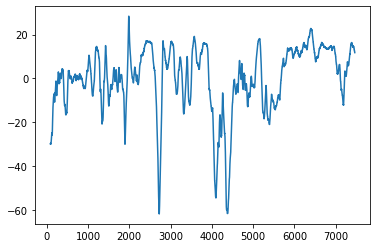

In [6]:
# Avg deniv for color
n=90
df['d_avg'] = df['elev_diff'].rolling(n).sum().round(2)
df.d_avg.plot()

In [50]:
# 3d GPS coordinates scatter
fig_3 = px.scatter_3d(df, x='longitude', y='latitude', z='elevation', color='d_avg', template='plotly_dark',hover_name='d+',title='3d profile - Elevation highlight')
fig_3.update_traces(marker=dict(size=3), selector=dict(mode='markers'))
fig_3.update_layout(scene = {"xaxis": {"nticks": 5},
                             "zaxis": {"nticks": 10},
                             "camera_eye": {"x": 0.3, "y": -1, "z": 0.3},
                             "aspectratio": {"x": 1, "y": 0.7, "z": 0.25}},
                    height=600
                   )

fig_3.show()

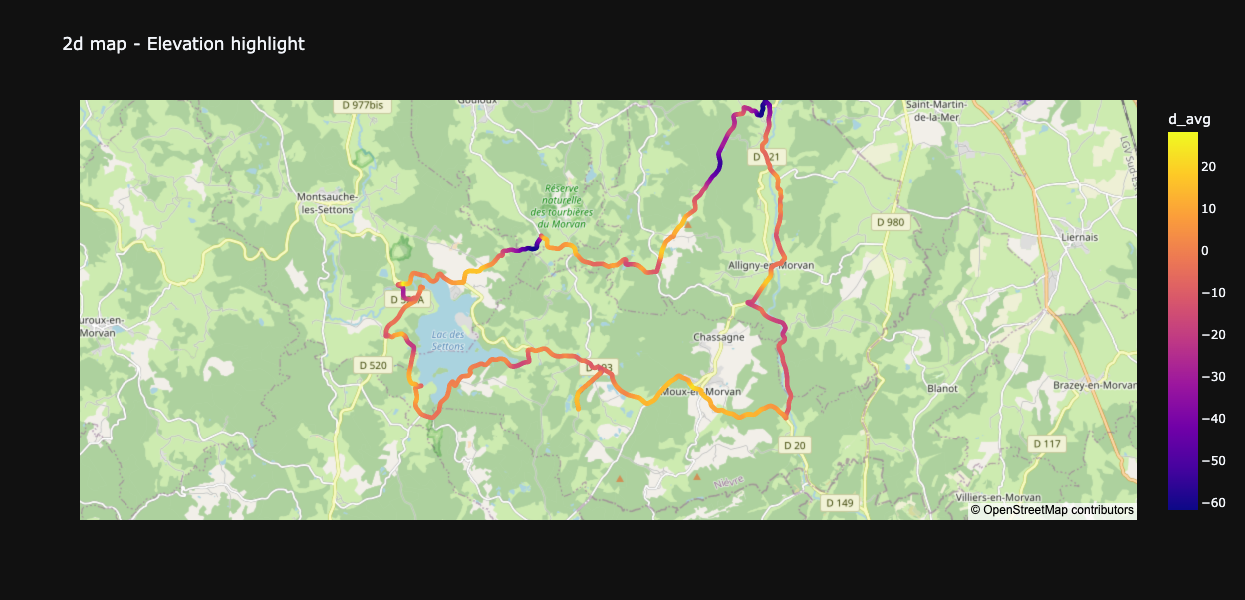

In [60]:
# 2d Map GPS coordinates - Free
fig_4 = px.scatter_mapbox(df, lat='latitude', lon='longitude', hover_name='d+',
                          mapbox_style="open-street-map",
                          zoom=11,
                          color='d_avg',
                          title='2d map - Elevation highlight',
                          template='plotly_dark',
                          height=600
                      )
fig_4.update_traces(marker=dict(size=5), selector=dict(mode='markers'))

fig_4.show()

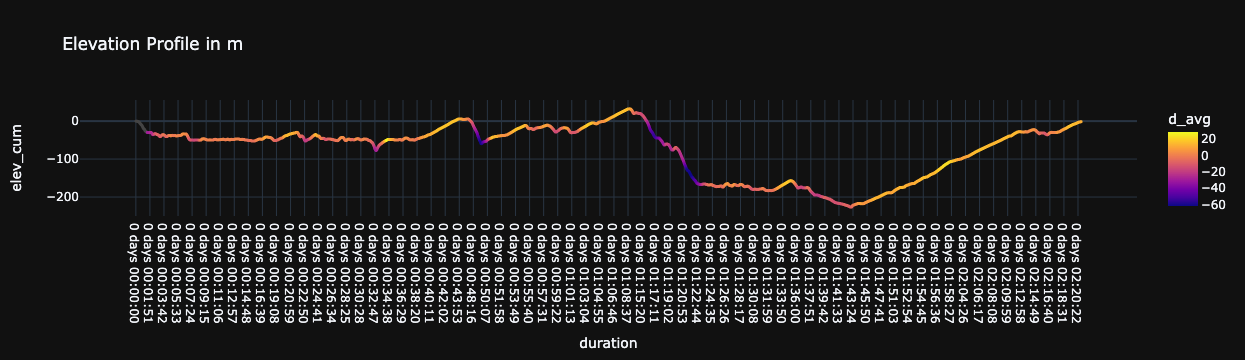

In [61]:
fig_2 = px.scatter(df, x='duration', y='elev_cum',color='d_avg',template='plotly_dark',hover_name='d+',title='Elevation Profile in m')
fig_2.update_traces(marker=dict(size=3), selector=dict(mode='markers'))

fig_2.show()

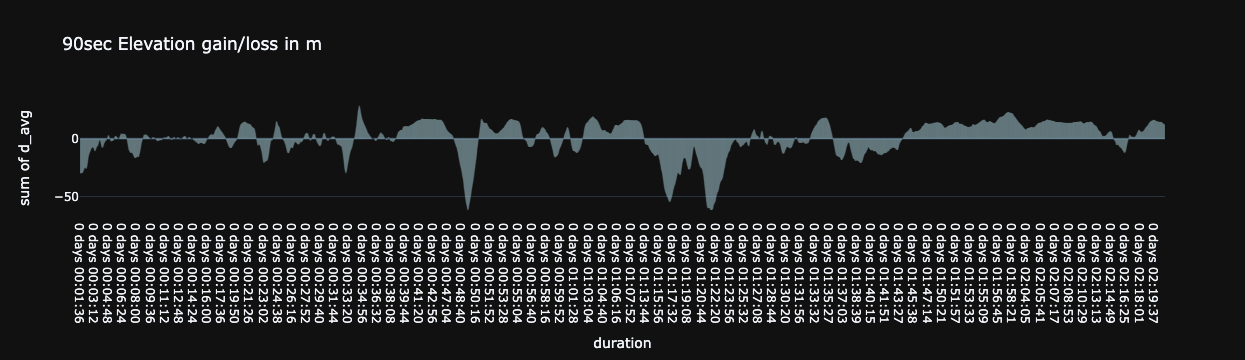

In [89]:
fig_1 = px.histogram(df, x='duration', y='d_avg',template='plotly_dark',hover_name='d+',title='90sec Elevation gain/loss in m',color_discrete_sequence=['lightblue'],opacity=0.85)
fig_1.update_traces(marker=dict(size=3), selector=dict(mode='markers'))

fig_1.show()

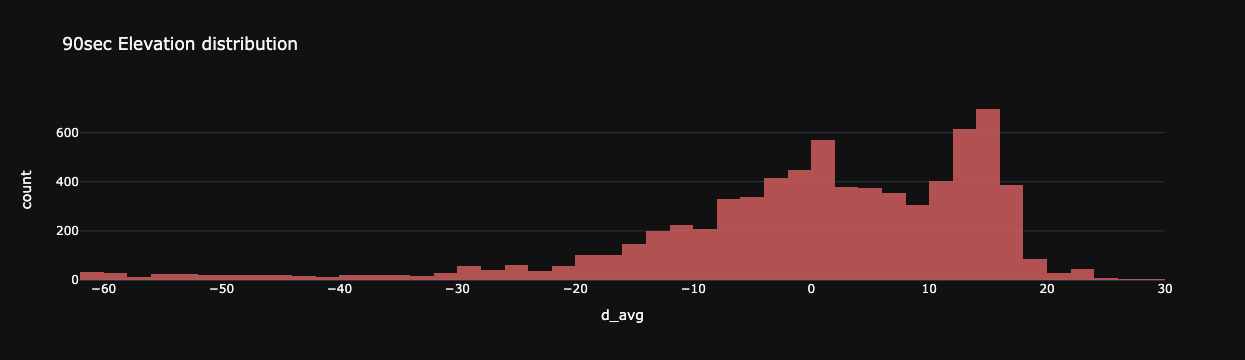

In [90]:
fig_5 = px.histogram(df, x='d_avg',template='plotly_dark',hover_name='d+',title='90sec Elevation distribution',nbins=50,color_discrete_sequence=['indianred'],opacity=0.85)
fig_5.update_traces(marker=dict(size=3), selector=dict(mode='markers'))

fig_5.show()

## Dash by plotly

In [91]:
#!pip install dash-bootstrap-components

In [92]:
import dash
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import Input,Output
import dash_bootstrap_components as dbc

In [93]:
# Dash generic template + layout design
#app = JupyterDash(__name__)
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

title = html.H1("GPX Viewer App")

map_2d = dcc.Graph(figure=fig_4)
map_3d = dcc.Graph(figure=fig_3)
elev_line = dcc.Graph(figure=fig_2)
d_avg = dcc.Graph(figure=fig_1)
histo = dcc.Graph(figure=fig_5)

row_1 = map_2d
row_2 = map_3d
row_3 = elev_line
row_4 = d_avg
row_5 = histo

app.layout = html.Div([
    title,
    row_1,
    row_2,
    row_3,
    row_4,
    row_5
])

            

In [94]:
# to run the app
app.run_server()

Dash app running on http://127.0.0.1:8050/
